<a href="https://colab.research.google.com/github/aymensrihi/deep-learning-projects/blob/main/domaingeneralisationvit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 339kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.31MB/s]



Epoch 1
Batch   1: Loss=2.3082, RB Loss=0.0000
Batch 101: Loss=1.9817, RB Loss=0.0019
Batch 201: Loss=1.7336, RB Loss=0.0010
Batch 301: Loss=1.5894, RB Loss=0.0000
Batch 401: Loss=1.5796, RB Loss=0.0174
Batch 501: Loss=1.3558, RB Loss=0.0066
Batch 601: Loss=1.3026, RB Loss=0.0000
Batch 701: Loss=1.2933, RB Loss=0.0350
Batch 801: Loss=1.1778, RB Loss=0.0427
Batch 901: Loss=1.0289, RB Loss=0.0629
==> Epoch 1 Summary: Total Loss=1.4665, Avg RB Loss=0.0133, Accuracy=60.01%

Epoch 2
Batch   1: Loss=0.8244, RB Loss=0.0230
Batch 101: Loss=0.9471, RB Loss=0.0297
Batch 201: Loss=0.9939, RB Loss=0.0000
Batch 301: Loss=0.7669, RB Loss=0.0000
Batch 401: Loss=0.6951, RB Loss=0.0426
Batch 501: Loss=0.9338, RB Loss=0.1517
Batch 601: Loss=0.7237, RB Loss=0.0000
Batch 701: Loss=0.6448, RB Loss=0.1870
Batch 801: Loss=0.4418, RB Loss=0.1271
Batch 901: Loss=0.8125, RB Loss=0.1410
==> Epoch 2 Summary: Total Loss=0.7717, Avg RB Loss=0.0714, Accuracy=82.77%

Epoch 3
Batch   1: Loss=0.5188, RB Loss=0.0000
Ba

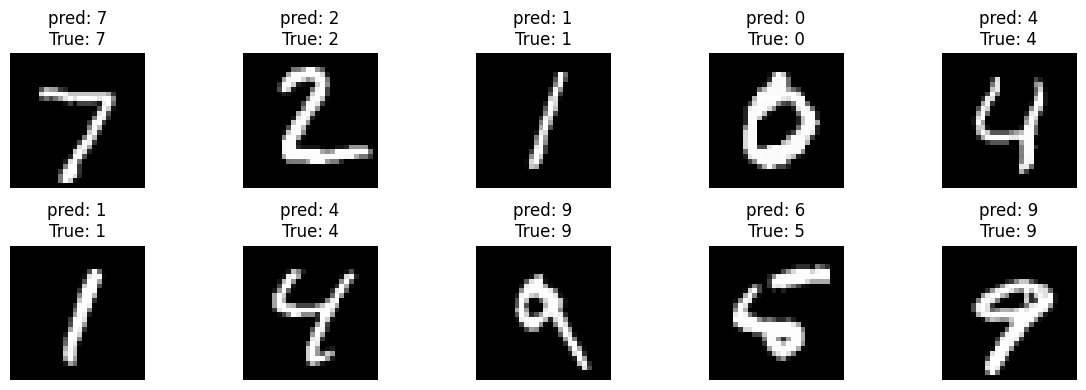

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import math
import random
import matplotlib.pyplot as plt

# From the first snippet, simplified and fixed for MNIST
# Removed timm dependencies, hybrid backbones, pretrained loading
# Adjusted for grayscale 28x28 images, patch_size=7
# Kept layer-wise outputs as in the snippet for forward_features
# Added ERM_SPSDViT but simplified without domain, since no multi-domain in MNIST
# For demonstration, use standard ERM training, but include the random block selection in predict_Train

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, return_attention=False):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn_copy = attn
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        if return_attention:
            return x, attn_copy
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = nn.Identity()  # No DropPath for simplicity
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        if return_attention:
            attn, attn_copy = self.attn(self.norm1(x), return_attention=True)
            x = x + self.drop_path(attn)
            x = x + self.drop_path(self.mlp(self.norm2(x)))
            return x, attn_copy
        else:
            attn = self.attn(self.norm1(x))
            x = x + self.drop_path(attn)
            x = x + self.drop_path(self.mlp(self.norm2(x)))
            return x

class PatchEmbed(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_chans=1, embed_dim=768):
        super().__init__()
        img_size = (img_size, img_size) if isinstance(img_size, int) else img_size
        patch_size = (patch_size, patch_size) if isinstance(patch_size, int) else patch_size
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_chans=1, num_classes=10, embed_dim=64, depth=4, num_heads=4, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim) * 0.02)
        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [0. for i in range(depth)]  # no drop path
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer
            )
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            m.weight.data = torch.randn(m.weight.size()) * 0.02
            if m.bias is not None:
                m.bias.data.fill_(0)
        elif isinstance(m, nn.LayerNorm):
            m.bias.data.fill_(0)
            m.weight.data.fill_(1.0)

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        layer_wise_tokens = []
        for blk in self.blocks:
            x = blk(x)
            layer_wise_tokens.append(x)
        layer_wise_tokens = [self.norm(t) for t in layer_wise_tokens]
        return [t[:, 0] for t in layer_wise_tokens]

    def forward(self, x, return_feat=False):
        list_out = self.forward_features(x)
        features = list_out
        x = [self.head(t) for t in list_out]
        if return_feat:
            return x, features
        else:
            return x

class Algorithm(nn.Module):
    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(Algorithm, self).__init__()
        self.hparams = hparams

class ERM_SPSDViT(Algorithm):
    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(ERM_SPSDViT, self).__init__(input_shape, num_classes, num_domains, hparams)
        self.alpha_rb_loss = self.hparams['RB_loss_weight']
        self.alpha_KL_temp = self.hparams['KL_Div_Temperature']
        self.network = VisionTransformer()
        self.optimizer = torch.optim.AdamW(self.network.parameters(), lr=self.hparams["lr"], weight_decay=self.hparams['weight_decay'])
        self.alpha_T = self.hparams['alpha_T']
        self.n_steps = self.hparams['n_steps']
        self.step_count = 0
        self.n_classes = num_classes

    def update(self, x, y):
        self.network.train()
        alpha_t = self.alpha_T * ((self.step_count + 1) / self.n_steps)
        alpha_t = max(0, alpha_t)
        output, output_rb = self.predict_Train(x)
        targets_numpy = y.cpu().detach().numpy()
        identity_matrix = torch.eye(self.n_classes)
        targets_one_hot = identity_matrix[targets_numpy].to(x.device)
        soft_output = ((1 - alpha_t) * targets_one_hot) + (alpha_t * F.softmax(output, dim=1))
        soft_output_rb = ((1 - alpha_t) * targets_one_hot) + (alpha_t * F.softmax(output_rb, dim=1))
        self.step_count += 1
        base_loss = F.cross_entropy(output, y)
        rb_loss = F.kl_div(
            torch.log(soft_output_rb + 1e-10),
            torch.log(soft_output + 1e-10),
            reduction='sum',
            log_target=True
        ) * (self.alpha_KL_temp * self.alpha_KL_temp) / output_rb.numel()
        loss = base_loss + self.alpha_rb_loss * rb_loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return {'loss': loss.item(), 'rb_loss': rb_loss.item()}

    def predict_Train(self, x):
        out = self.network(x)
        block_number = random.randint(0, len(out) - 1)
        return out[-1], out[block_number]

    def predict(self, x):
        out = self.network(x)
        return out[-1]

# Hyperparameters (simplified, since no domain)
hparams = {
    'RB_loss_weight': 0.7,
    'KL_Div_Temperature': 4.0,
    'alpha_T': 0.8,
    'n_steps': 5000,
    'lr': 5e-5,
    'weight_decay': 0.0,
    'batch_size': 64,
}

# MNIST setup
transformation_operation = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transformation_operation)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transformation_operation)

train_loader = DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=False)

num_classes = 10
input_shape = (1, 28, 28)
num_domains = 1  # Single domain for MNIST

model = ERM_SPSDViT(input_shape, num_classes, num_domains, hparams)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Note: ERM_SPSDViT is the algorithm, network is inside

epochs = 5
for epoch in range(epochs):
    total_loss = 0
    rb_loss_total = 0
    correct_epoch = 0
    total_epoch = 0
    print(f"\nEpoch {epoch+1}")
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        metrics = model.update(images, labels)
        total_loss += metrics['loss']
        rb_loss_total += metrics['rb_loss']
        outputs = model.predict(images)
        preds = outputs.argmax(dim=1)
        correct = (preds == labels).sum().item()
        correct_epoch += correct
        total_epoch += labels.size(0)
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx+1:3d}: Loss={metrics['loss']:.4f}, RB Loss={metrics['rb_loss']:.4f}")
    epoch_acc = 100.0 * correct_epoch / total_epoch
    avg_loss = total_loss / len(train_loader)
    avg_rb_loss = rb_loss_total / len(train_loader)
    print(f"==> Epoch {epoch+1} Summary: Total Loss={avg_loss:.4f}, Avg RB Loss={avg_rb_loss:.4f}, Accuracy={epoch_acc:.2f}%")

# Evaluation and plot, like the second
model.network.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    outputs = model.predict(images)
preds = outputs.argmax(dim=1)
images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

plt.figure(figsize=(12,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()